# Lecture 21 + Lecture 22: Gelu Function and Feed Forward Neural Network and Short Cut Connections

In [468]:
import torch
import matplotlib.pyplot as plt
from torch import nn

In [469]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

# GELU Function

In [470]:
class Gelu(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2) / torch.pi) * (x + 0.044715 * torch.pow(x, 3))))

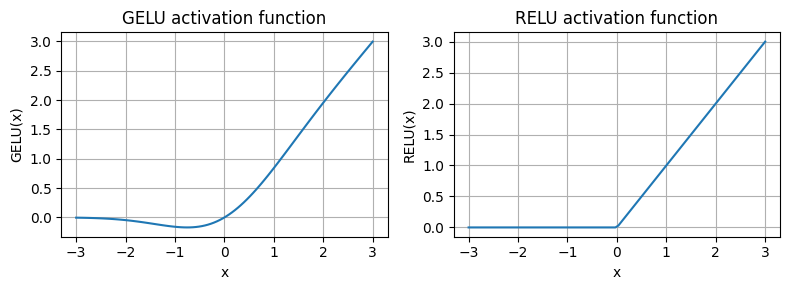

In [471]:
gelu, relu = Gelu(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu.forward(x), relu.forward(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "RELU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()



### - smoothness of the gelu lead to better optimization properties during training
### - sharp corner at 0 can cause difficulties during training using the relu function
### - gelu allows for negative input, if neurons recieve negative input they will not be 0 like in relu (dead neuron)

### in relu neurons with x-values 0 or smaller will not contribute to the learning because their responding y-value becomes 0

### in gelu neurons with a x-value smaller 0 have a responding y-value smaller zero and will still contribute to the learning

### NN taking in 1 token at a time and modifying each dimension of this token
### projection into higher dimensional space allows for enriched exploration space, capturing more properties
### through expansion - contraction the dimensions of the inputs are still preserved

### FFNN looking at one token at a time, in contrast to the Attention Mechanism which looked at one token and its relationships to the remaining tokens, excluding any future tokens and creating a context vector 

# Feed Forward Neural Network

## Feed Forward Neural Network taking in the context aware representations of the the token embeddings, basically the output of the Attention Mechanism

In [472]:
class FFNeuralNetwork(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            Gelu(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )
    
    def forward(self, x):
        return self.layer_stack(x)


### implementing the Gelu class which has been defined earlier instead of using nn.GELU

In [473]:
emb_dim = GPT_CONFIG_124M["emb_dim"]
print(emb_dim)

768


In [474]:
torch.manual_seed(42)
ffn = FFNeuralNetwork(GPT_CONFIG_124M)
x = torch.rand(2, 3, emb_dim)
output = ffn.forward(x)
print(f"NN Input:\n{x}\n{x.shape}\n")
print(f"NN Output:\n{output}\n{output.shape}")

NN Input:
tensor([[[0.2815, 0.4409, 0.8385,  ..., 0.9403, 0.4100, 0.4194],
         [0.6080, 0.6430, 0.1016,  ..., 0.4817, 0.4101, 0.7624],
         [0.0747, 0.2672, 0.2204,  ..., 0.5120, 0.4807, 0.2112]],

        [[0.1777, 0.4846, 0.2280,  ..., 0.8644, 0.8779, 0.2210],
         [0.4833, 0.4693, 0.6961,  ..., 0.4659, 0.1652, 0.3268],
         [0.1802, 0.8846, 0.1620,  ..., 0.7178, 0.4618, 0.7873]]])
torch.Size([2, 3, 768])

NN Output:
tensor([[[-0.0054, -0.0797,  0.0663,  ...,  0.2233, -0.0117,  0.0114],
         [ 0.0144,  0.0674,  0.0832,  ...,  0.2315, -0.0773, -0.0503],
         [-0.0314, -0.0265,  0.0826,  ...,  0.2011, -0.0109, -0.0348]],

        [[-0.0012,  0.0061,  0.0253,  ...,  0.2241,  0.0202,  0.1021],
         [-0.0053, -0.0930,  0.1117,  ...,  0.1725, -0.0275, -0.0050],
         [ 0.0241, -0.0798,  0.0792,  ...,  0.2272,  0.0785, -0.0843]]],
       grad_fn=<ViewBackward0>)
torch.Size([2, 3, 768])


# Short Cut Connections

In [475]:
class DeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layer_stack = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), nn.GELU())
        ])
    
    def forward(self, x):
        for layer in self.layer_stack:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [476]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()

    values = []
    for name, param in model.named_parameters():
        if "weight" in name:
            values.append(f"{name} has gradient mean of {param.grad.abs().mean().item()}")
    return "\n".join(values)

## creating an instance of the class setting use_shortcut to False

#### magnitude of the gradient decreases and nearly reaches 0 during lossbackward (vanishing gradient)

In [477]:
torch.manual_seed(123)
layer_sizes = [3, 3, 3, 3, 3, 1]
input_nn = torch.tensor([[1., 0., -1.]])

neural_network_no_shortcut = DeepNeuralNetwork(layer_sizes, use_shortcut=False)
demo_no_shortcut = print_gradients(neural_network_no_shortcut, input_nn)
print(f"{demo_no_shortcut}\n")


layer_stack.0.0.weight has gradient mean of 0.0002017411752603948
layer_stack.1.0.weight has gradient mean of 0.00012011770741082728
layer_stack.2.0.weight has gradient mean of 0.0007152436301112175
layer_stack.3.0.weight has gradient mean of 0.0013988513965159655
layer_stack.4.0.weight has gradient mean of 0.005049605388194323



In [478]:
class DeepNeuralNetwork1(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layer_stack = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), nn.GELU())
        ])
    
    def forward(self, x):
        for layer in self.layer_stack:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

## creating an instance of the class setting use_shortcut to True

#### magnitude of the gradient stabelizes during lossbackward (no vanishing gradient)

In [479]:
torch.manual_seed(123)
layer_sizes = [3, 3, 3, 3, 3, 1]
input_nn1 = torch.tensor([[1., 0., -1.]])

neural_network_use_shortcut = DeepNeuralNetwork1(layer_sizes, use_shortcut=True)
demo_with_shortcut = print_gradients(neural_network_use_shortcut, input_nn1)
print(f"{demo_with_shortcut}")

layer_stack.0.0.weight has gradient mean of 0.22186797857284546
layer_stack.1.0.weight has gradient mean of 0.20709273219108582
layer_stack.2.0.weight has gradient mean of 0.32923877239227295
layer_stack.3.0.weight has gradient mean of 0.2667772173881531
layer_stack.4.0.weight has gradient mean of 1.3268063068389893
